# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import math
from sklearn.metrics import classification_report, plot_confusion_matrix
warnings.filterwarnings('ignore')
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

In [2]:
##config
w=0.3 # labeling parameter
method = 'price' #log_returns
target = 'class'
scaling =  'standard'#/'minmax'
cutoff_date = '2021-01-01 00:00:00+00:00'
window_size = 36

In [3]:
prices = pd.read_csv('prices_new.csv', parse_dates=True, index_col='datetime')
btc = pd.DataFrame(prices['closePriceUsd'])
btc.columns = ['price']
btc.head()

,price
datetime,
2017-05-29 00:00:00+00:00,2202.22
2017-05-29 12:00:00+00:00,2255.61
2017-05-30 00:00:00+00:00,2292.66
2017-05-30 12:00:00+00:00,2175.47
2017-05-31 00:00:00+00:00,2222.84


# Functions

In [4]:
def calculate_returns(prices, labels):
    """
    functions which calculate ROI based on price and labels
    df: dataframe with asset price column ('price') and label column ('class')
    """
    pct = prices.pct_change()
    R = 1
    for i in range(1, len(pct)):
        if labels[i] == 1:
            R = R*(1+pct[i])
    return R-1

In [5]:
def calculate_returns_with_short(prices, labels):
    """
    functions which calculate ROI based on price and labels
    df: dataframe with asset price column ('price') and label column ('class')
    """
    pct = prices.pct_change()
    R = 1
    for i in range(1, len(pct)):
        if labels[i] == 1:
            R *= (1+pct[i])
        if labels[i] == 0:
            R *= (1-pct[i])
    return R-1

In [6]:
def buy_and_hold_return(prices):
    """
    prices: pd series of prices
    """
    return prices[-1]/prices[0] - 1

In [7]:
def plot_results(prices, labels, asset = 'btc', title=''):
    """
    functions which plots asset price (or whatever) alongside label
    """
    diff = abs(labels.diff())
    xcoords = prices.index[np.where(diff>0)]
    xcoords
    fig, (ax_sig1, ax_sig2) = plt.subplots(2, 1, sharex=True, figsize= (16,8))
    fig.suptitle(title)
    ax_sig1.plot(prices, 'r-')
    ax_sig1.set_title(asset)
    ax_sig2.plot(labels)
    for xc in xcoords:
        ax_sig1.axvline(x=xc, color='k', linestyle='--', alpha=0.4)
        ax_sig2.axvline(x=xc, color='k', linestyle='--', alpha=0.4)

    ax_sig2.set_title(f'label')
    plt.show()


In [8]:
def add_lag_features(data, column, lags):
    for i in range(1, lags+1):
        data[f'lag_{i}'] = data[column].shift(i)

In [9]:
def check_number_lags(data):     
    n_lag = 0
    while f'lag_{n_lag+1}' in data.columns :
        n_lag = n_lag + 1
    return n_lag

In [10]:
def maj_lag(data):
    
    #check number of lags into the df
    n_lag = check_number_lags(data)
    
    #create list of majority lag
    y=[]
    for index, row in data.iterrows():
        count = 0
        for i in range(1, n_lag ):
            if row[f'lag_{i}'] > 0:
                count +=1
                
        if count >= (math.floor(n_lag/2)):
            y.append(1)
        else :
             y.append(0)
    
    #create new column with y 
    data['maj_lag'] = y 
    return data
               

In [11]:
def most_naive_pred(data):
       return np.array([1 if x > 0 else 0 for x in data])

In [12]:
def classify_and_report(model, printing = True):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred = pd.Series(y_pred, index = y_test.index)
    print(classification_report(y_test, y_pred))
    plot_confusion_matrix(model,X_test, y_test)
    prices = btc['price'].loc[X_test.index].copy()
    if printing:
        plot_results(prices , y_pred)
        print('Model Returns: ', calculate_returns(prices, y_pred))
        print('Model Returns with short: ', calculate_returns_with_short(prices, y_pred))
        print('Buy and hold Returns: ', buy_and_hold_return(prices))
    return y_pred

In [13]:
btc.head()

,price
datetime,
2017-05-29 00:00:00+00:00,2202.22
2017-05-29 12:00:00+00:00,2255.61
2017-05-30 00:00:00+00:00,2292.66
2017-05-30 12:00:00+00:00,2175.47
2017-05-31 00:00:00+00:00,2222.84


# Labelling

## Naive labeling (using one previous point)

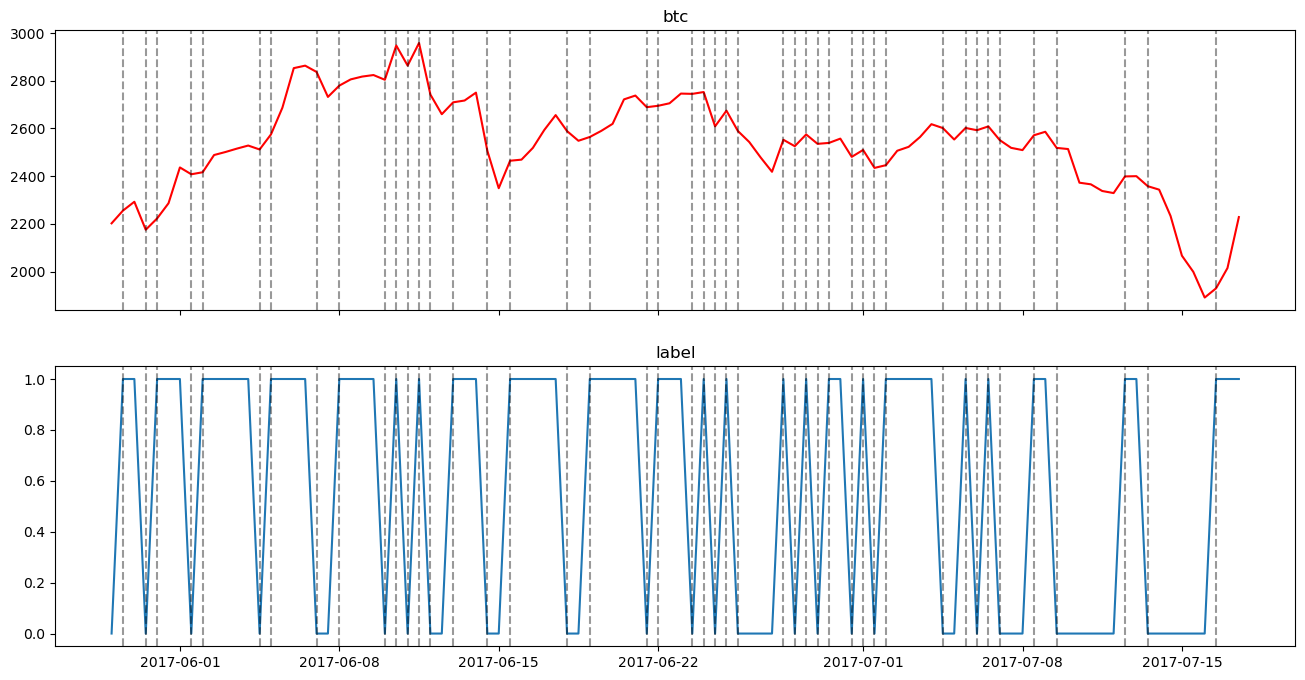

In [14]:
btc['naive_class'] = most_naive_pred(btc['price'].diff())
btc['naive_class'] = btc['naive_class'].astype('int')
plot_results(btc['price'][:100], btc['naive_class'][:100])

In [15]:
btc

,price,naive_class
datetime,,
2017-05-29 00:00:00+00:00,2202.220000,0
2017-05-29 12:00:00+00:00,2255.610000,1
2017-05-30 00:00:00+00:00,2292.660000,1
2017-05-30 12:00:00+00:00,2175.470000,0
2017-05-31 00:00:00+00:00,2222.840000,1
...,...,...
2022-02-13 12:00:00+00:00,42197.515341,0
2022-02-14 00:00:00+00:00,42154.454730,0
2022-02-14 12:00:00+00:00,42586.919686,1


In [16]:
cutoff_down_start = '2021-03-15 00:00:00+00:00'
cutoff_down_end = '2021-07-01 00:00:00+00:00'
cutoff_up_start = '2021-07-15 00:00:00+00:00'
cutoff_up_end = '2021-11-01 00:00:00+00:00'
cutoff_date = '2021-01-01 00:00:00+00:00'
diverse_end = '2021-07-01 00:00:00+00:00'
diverse_cutoff = '2021-01-01 00:00:00+00:00'

 ### Diverse market (mixed trend)

In [17]:
y_pred_naive = btc['naive_class'].shift(1).dropna()
print(classification_report(btc['naive_class'].loc[cutoff_date:], y_pred_naive.loc[cutoff_date:]))

              precision    recall  f1-score   support

           0       0.46      0.46      0.46       397
           1       0.50      0.50      0.50       425

    accuracy                           0.48       822
   macro avg       0.48      0.48      0.48       822
weighted avg       0.48      0.48      0.48       822



 ### Bearish market (downtrend)

In [18]:
print(classification_report(btc['naive_class'].loc[cutoff_down_start:cutoff_down_end], y_pred_naive.loc[cutoff_down_start:cutoff_down_end]))

              precision    recall  f1-score   support

           0       0.45      0.45      0.45       110
           1       0.43      0.43      0.43       107

    accuracy                           0.44       217
   macro avg       0.44      0.44      0.44       217
weighted avg       0.44      0.44      0.44       217



 ###  Bullish market (uptrend)

In [19]:
print(classification_report(btc['naive_class'].loc[cutoff_up_start:cutoff_up_end], y_pred_naive.loc[cutoff_up_start:cutoff_up_end]))

              precision    recall  f1-score   support

           0       0.42      0.42      0.42       100
           1       0.51      0.51      0.51       119

    accuracy                           0.47       219
   macro avg       0.47      0.47      0.47       219
weighted avg       0.47      0.47      0.47       219



## Return calculation based on naive model 

### Diverse market (mixed trend)

In [20]:
print('Model Returns: ', calculate_returns(btc['price'][cutoff_date:diverse_end], y_pred_naive[cutoff_date:diverse_end]))
print('Model Returns with short: ', calculate_returns_with_short(btc['price'][cutoff_date:], y_pred_naive[cutoff_date:]))
print('Buy and hold Returns: ', buy_and_hold_return(btc['price'][cutoff_date:diverse_end]))

Model Returns:  0.21066407174046908
Model Returns with short:  -0.4836002358570678
Buy and hold Returns:  0.14806390008863413


### Bearish market (downtrend)

In [21]:
print('Model Returns: ', calculate_returns(btc['price'][cutoff_down_start:cutoff_down_end], y_pred_naive[cutoff_down_start:cutoff_down_end]))
print('Model Returns with short: ', calculate_returns_with_short(btc['price'][cutoff_down_start:cutoff_down_end], y_pred_naive[cutoff_down_start:cutoff_down_end]))
print('Buy and hold Returns: ', buy_and_hold_return(btc['price'][cutoff_down_start:cutoff_down_end]))

Model Returns:  -0.42543739424109706
Model Returns with short:  -0.5216902922435331
Buy and hold Returns:  -0.40146171373623796


### Bullish market (uptrend)

In [22]:
print('Model Returns: ', calculate_returns(btc['price'][cutoff_up_start:cutoff_up_end], y_pred_naive[cutoff_up_start:cutoff_up_end]))
print('Model Returns with short: ', calculate_returns_with_short(btc['price'][cutoff_up_start:cutoff_up_end], y_pred_naive[cutoff_up_start:cutoff_up_end]))
print('Buy and hold Returns: ', buy_and_hold_return(btc['price'][cutoff_up_start:cutoff_up_end]))

Model Returns:  0.1792338903167472
Model Returns with short:  -0.33628425975156095
Buy and hold Returns:  0.9385295483390821


## Naive labelling - majority vote

In [23]:
#create dataframe of difference
naive_with_lag = pd.DataFrame(data = btc['price'].diff().values , index = btc.index ,columns = ['lag_naive_price'])
#create df of lag of diff
add_lag_features(naive_with_lag , 'lag_naive_price' , window_size)
#drop na
naive_with_lag.dropna(inplace=True)
#new column with maj of lag
naive_with_lag = maj_lag(naive_with_lag)
naive_with_lag

,lag_naive_price,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,...,lag_28,lag_29,lag_30,lag_31,lag_32,lag_33,lag_34,lag_35,lag_36,maj_lag
datetime,,,,,,,,,,,,,,,,,,,,,
2017-06-16 12:00:00+00:00,49.340000,4.640000,115.140000,-156.930000,-243.680000,33.030000,7.560000,49.830000,-82.290000,-216.190000,...,72.170000,8.500000,-28.640000,150.110000,63.570000,47.370000,-117.190000,37.050000,53.390000,1
2017-06-17 00:00:00+00:00,74.950000,49.340000,4.640000,115.140000,-156.930000,-243.680000,33.030000,7.560000,49.830000,-82.290000,...,12.650000,72.170000,8.500000,-28.640000,150.110000,63.570000,47.370000,-117.190000,37.050000,1
2017-06-17 12:00:00+00:00,62.370000,74.950000,49.340000,4.640000,115.140000,-156.930000,-243.680000,33.030000,7.560000,49.830000,...,14.150000,12.650000,72.170000,8.500000,-28.640000,150.110000,63.570000,47.370000,-117.190000,1
2017-06-18 00:00:00+00:00,-67.070000,62.370000,74.950000,49.340000,4.640000,115.140000,-156.930000,-243.680000,33.030000,7.560000,...,12.930000,14.150000,12.650000,72.170000,8.500000,-28.640000,150.110000,63.570000,47.370000,1
2017-06-18 12:00:00+00:00,-40.520000,-67.070000,62.370000,74.950000,49.340000,4.640000,115.140000,-156.930000,-243.680000,33.030000,...,-16.470000,12.930000,14.150000,12.650000,72.170000,8.500000,-28.640000,150.110000,63.570000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-02-13 12:00:00+00:00,-304.617921,257.663275,-156.324123,-7.143828,-974.401114,-182.773120,-1283.717651,510.032066,586.472124,-366.120626,...,-188.549412,-30.323186,380.562950,-28.420883,1341.371722,-695.272774,496.227989,-210.116268,-1188.799424,0
2022-02-14 00:00:00+00:00,-43.060611,-304.617921,257.663275,-156.324123,-7.143828,-974.401114,-182.773120,-1283.717651,510.032066,586.472124,...,-658.081381,-188.549412,-30.323186,380.562950,-28.420883,1341.371722,-695.272774,496.227989,-210.116268,0
2022-02-14 12:00:00+00:00,432.464957,-43.060611,-304.617921,257.663275,-156.324123,-7.143828,-974.401114,-182.773120,-1283.717651,510.032066,...,1223.604957,-658.081381,-188.549412,-30.323186,380.562950,-28.420883,1341.371722,-695.272774,496.227989,0


In [24]:
btc_data = btc.copy()
add_lag_features(btc_data, method, window_size)
btc_data.dropna(inplace=True)
#because od diff , we lost one row
btc_data = btc_data[1:]
#add majority of lag column to btc_data
btc_data['maj_lag'] = naive_with_lag['maj_lag']

## Diverse market (mixed trend)

In [25]:
print(classification_report(btc_data['naive_class'][cutoff_date:],btc_data['maj_lag'][cutoff_date:] ))

              precision    recall  f1-score   support

           0       0.44      0.38      0.41       397
           1       0.49      0.56      0.52       425

    accuracy                           0.47       822
   macro avg       0.47      0.47      0.46       822
weighted avg       0.47      0.47      0.47       822



## Bearish market (downtrend)

In [26]:
print(classification_report(btc_data['naive_class'][cutoff_down_start:cutoff_down_end],btc_data['maj_lag'][cutoff_down_start:cutoff_down_end] ))

              precision    recall  f1-score   support

           0       0.43      0.42      0.43       110
           1       0.42      0.44      0.43       107

    accuracy                           0.43       217
   macro avg       0.43      0.43      0.43       217
weighted avg       0.43      0.43      0.43       217



## Bullish market (uptrend)

In [27]:
print(classification_report(btc_data['naive_class'][cutoff_up_start:cutoff_up_end] ,btc_data['maj_lag'][cutoff_up_start:cutoff_up_end]  ))

              precision    recall  f1-score   support

           0       0.39      0.24      0.30       100
           1       0.52      0.69      0.59       119

    accuracy                           0.48       219
   macro avg       0.46      0.46      0.45       219
weighted avg       0.46      0.48      0.46       219



## Return calculation based on majority vote model 

### Diverse market (mixed trend)

Model Returns:  0.10762353234699584
Model Returns with short:  0.09005976585384912
Buy and hold Returns:  0.14806390008863413


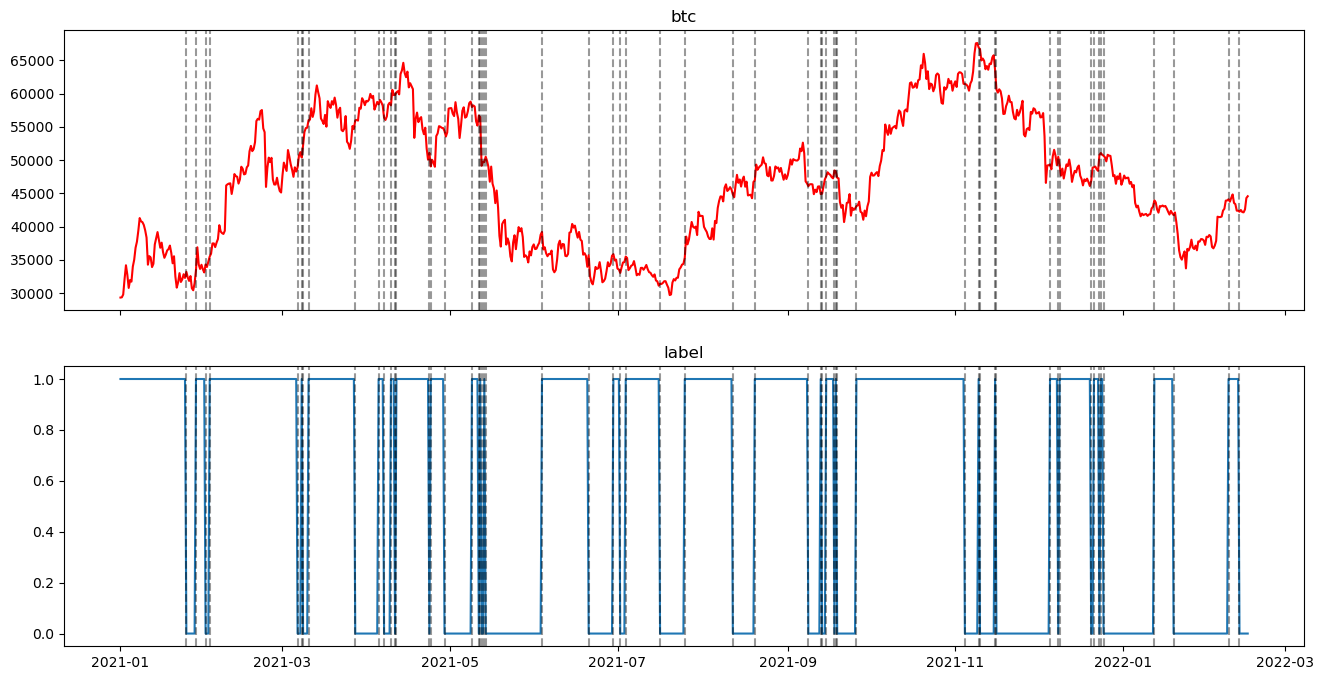

In [28]:
print('Model Returns: ', calculate_returns(btc_data['price'][cutoff_date:diverse_end], btc_data['maj_lag'][cutoff_date:diverse_end]))
print('Model Returns with short: ', calculate_returns_with_short(btc_data['price'][cutoff_date:], btc_data['maj_lag'][cutoff_date:]))
print('Buy and hold Returns: ', buy_and_hold_return(btc_data['price'][cutoff_date:diverse_end]))
plot_results(btc_data['price'][cutoff_date:], btc_data['maj_lag'][cutoff_date:])

### Bearish market (downtrend)

Model Returns:  -0.317429023964666
Model Returns with short:  -0.3235522229883513
Buy and hold Returns:  -0.40146171373623796


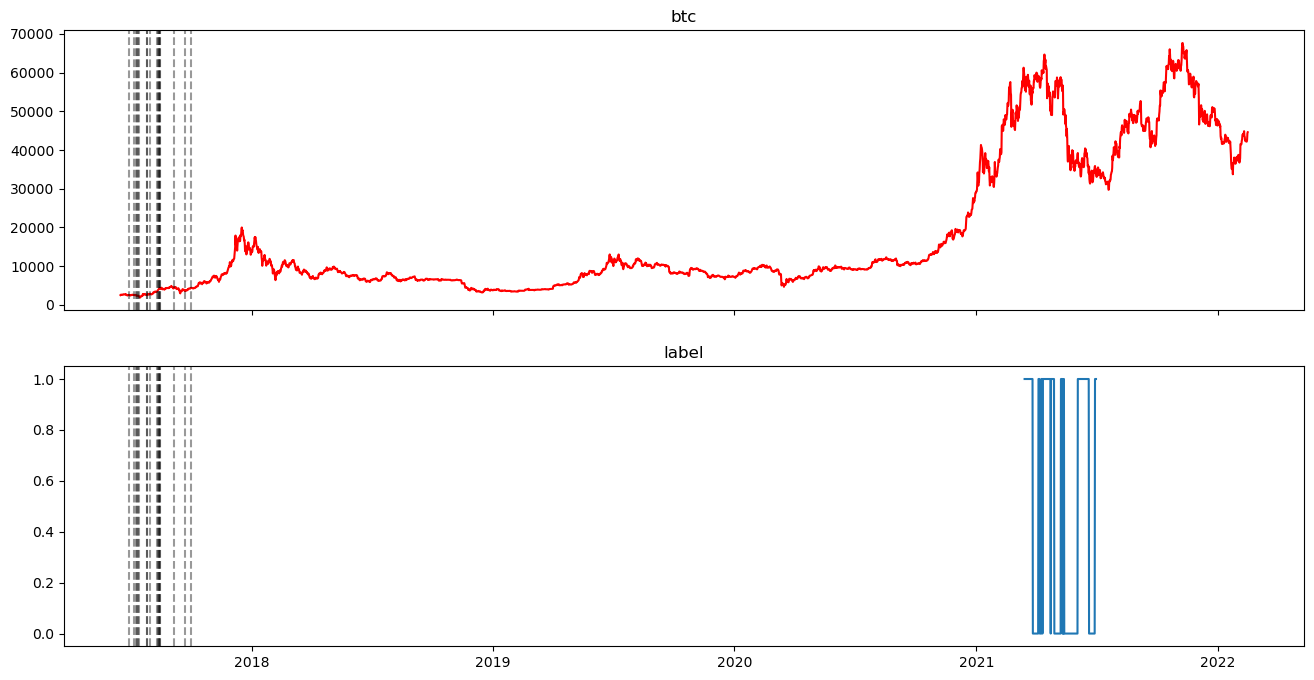

In [29]:
print('Model Returns: ', calculate_returns(btc_data['price'][cutoff_down_start:cutoff_down_end], btc_data['maj_lag'][cutoff_down_start:cutoff_down_end]))
print('Model Returns with short: ', calculate_returns_with_short(btc_data['price'][cutoff_down_start:cutoff_down_end], btc_data['maj_lag'][cutoff_down_start:cutoff_down_end]))
print('Buy and hold Returns: ', buy_and_hold_return(btc_data['price'][cutoff_down_start:cutoff_down_end]))
plot_results(btc_data['price'], btc_data['maj_lag'][cutoff_down_start:cutoff_down_end])

### Bullish market (uptrend)

Model Returns:  0.8168851284088348
Model Returns with short:  0.632516518616776
Buy and hold Returns:  0.9385295483390821


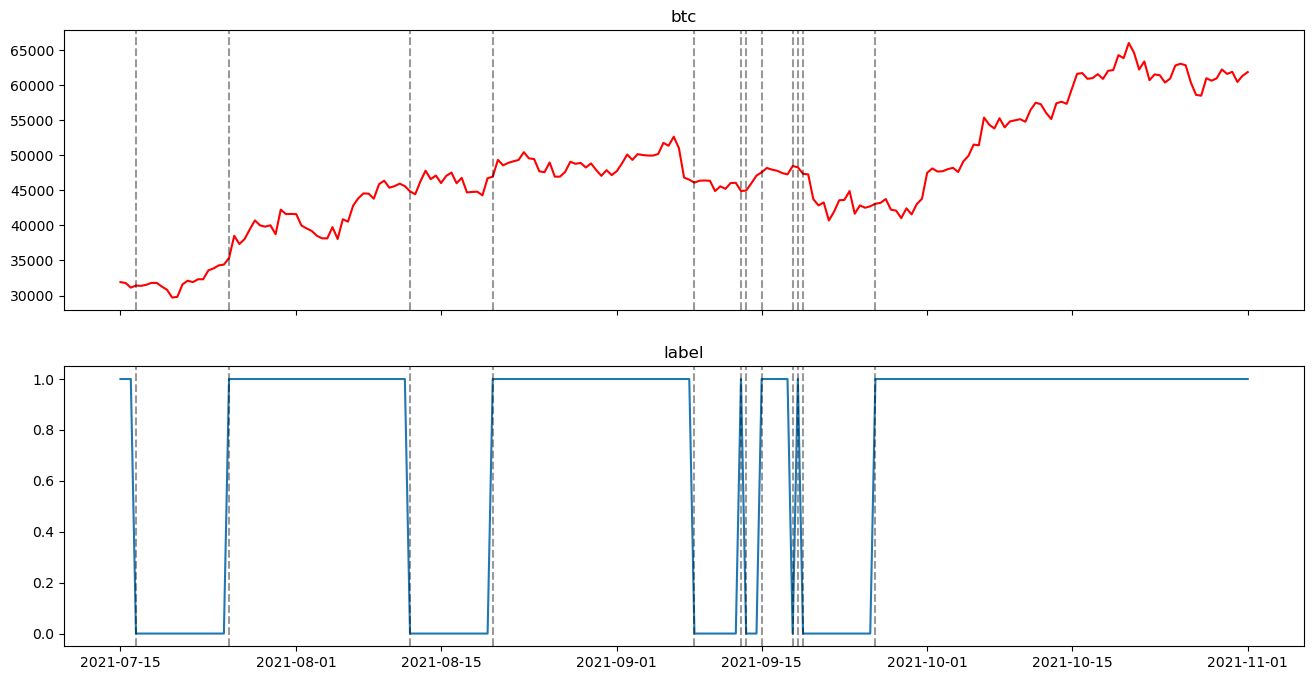

In [30]:
print('Model Returns: ', calculate_returns(btc_data['price'][cutoff_up_start:cutoff_up_end] , btc_data['maj_lag'][cutoff_up_start:cutoff_up_end] ))
print('Model Returns with short: ', calculate_returns_with_short(btc_data['price'][cutoff_up_start:cutoff_up_end] , btc_data['maj_lag'][cutoff_up_start:cutoff_up_end] ))
print('Buy and hold Returns: ', buy_and_hold_return(btc_data['price'][cutoff_up_start:cutoff_up_end] ))
plot_results(btc_data['price'][cutoff_up_start:cutoff_up_end] , btc_data['maj_lag'][cutoff_up_start:cutoff_up_end] )



# Modeling of naive labels

In [31]:
def classify_and_report(model, printing = True):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred = pd.Series(y_pred, index = y_test.index)
    print(classification_report(y_test, y_pred))
    plot_confusion_matrix(model,X_test, y_test)
    prices = btc['price'].loc[X_test.index].copy()
    if printing:
        plot_results(prices , y_pred)
        print('Model Returns: ', calculate_returns(prices, y_pred))
        print('Model Returns with short: ', calculate_returns_with_short(prices, y_pred))
        print('Buy and hold Returns: ', buy_and_hold_return(prices))
    return y_pred

In [32]:
cols =  ['price', 'naive_class','maj_lag']
X = btc_data.drop(columns= cols, axis=1)
y = btc_data['naive_class']

In [33]:
if method == 'price':
    if scaling == 'minmax':
        X = X.subtract(X.min(axis=1), axis=0)\
          .divide(X.max(axis=1) - X.min(axis=1), axis=0)\
          .combine_first(X)
    else:
        X = X.sub(X.mean(axis = 1), axis=0).div(X.std(axis = 1), axis=0)

In [34]:
X.iloc[0].mean()

-2.0477446898641774e-15

In [35]:
X_train = X.loc[:cutoff_up_start]
y_train = (y.loc[:cutoff_up_start] >0).astype(int)
X_test = X.loc[cutoff_up_start:cutoff_up_end] 
y_test = (y.loc[cutoff_up_start:cutoff_up_end] > 0).astype(int)

In [36]:
X_test_down = X.loc[cutoff_down_start:cutoff_down_end] 
y_test_down = (y.loc[cutoff_down_start:cutoff_down_end] > 0).astype(int)
X_test_up = X.loc[cutoff_up_start:cutoff_up_end] 
y_test_up = (y.loc[cutoff_up_start:cutoff_up_end] > 0).astype(int)

## ADABoost

In [37]:
ab_200 = AdaBoostClassifier(n_estimators=200)

### Diverse market (mixed trend)

In [38]:
X_train = X.loc[:diverse_cutoff ]
y_train = (y.loc[:diverse_cutoff ] >0).astype(int)
X_test = X.loc[diverse_cutoff :diverse_end ] 
y_test = (y.loc[diverse_cutoff :diverse_end ] > 0).astype(int)
cutoff_date:diverse_end

              precision    recall  f1-score   support

           0       0.50      0.46      0.48       172
           1       0.55      0.59      0.57       191

    accuracy                           0.53       363
   macro avg       0.52      0.52      0.52       363
weighted avg       0.52      0.53      0.52       363



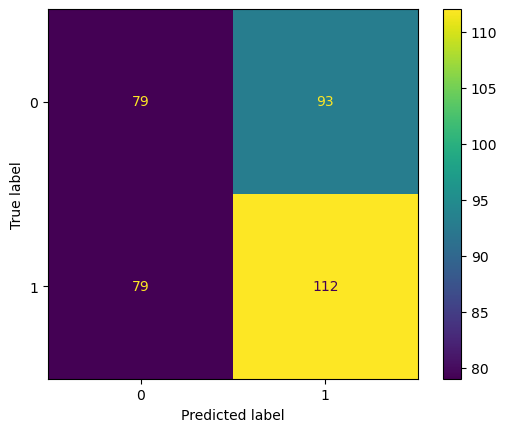

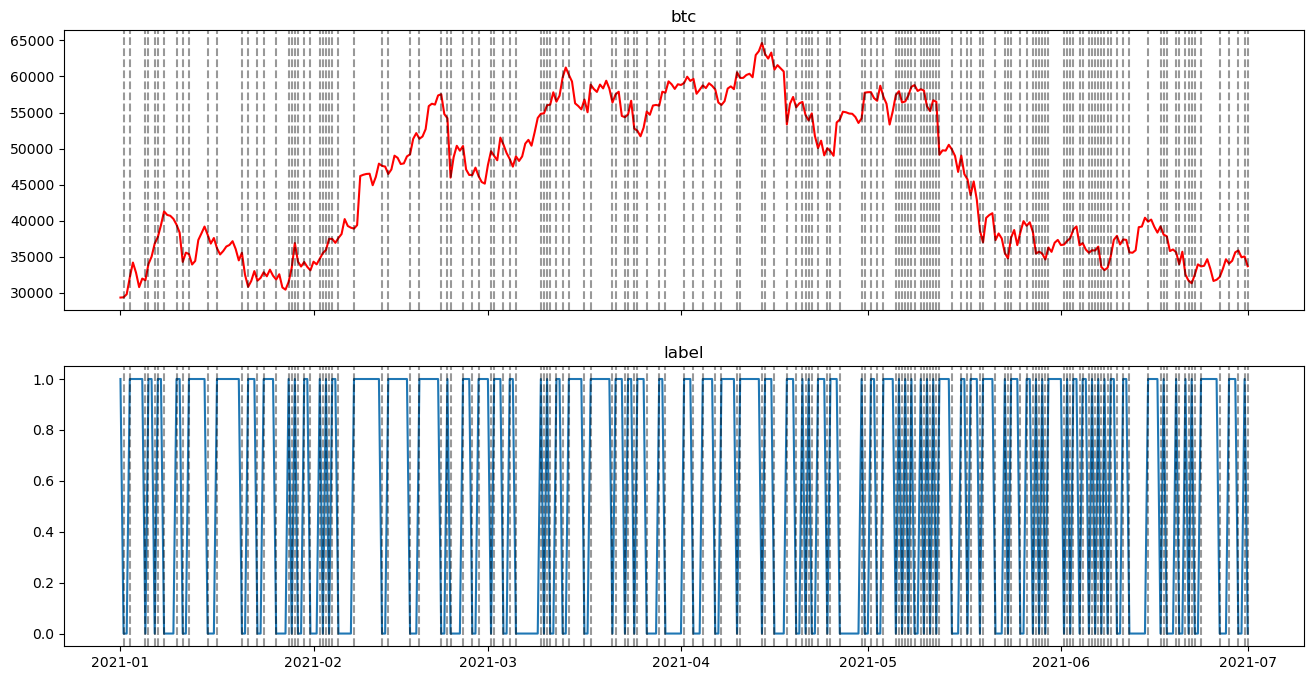

Model Returns:  0.5249088155031942
Model Returns with short:  0.661384327435149
Buy and hold Returns:  0.14806390008863413


datetime
2021-01-01 00:00:00+00:00    1
2021-01-01 12:00:00+00:00    0
2021-01-02 00:00:00+00:00    0
2021-01-02 12:00:00+00:00    1
2021-01-03 00:00:00+00:00    1
                            ..
2021-06-29 00:00:00+00:00    1
2021-06-29 12:00:00+00:00    0
2021-06-30 00:00:00+00:00    0
2021-06-30 12:00:00+00:00    1
2021-07-01 00:00:00+00:00    0
Length: 363, dtype: int32

In [39]:
classify_and_report(ab_200)

### Bearish market (downtrend)

In [40]:
X_train = X.loc[:cutoff_down_start]
y_train = (y.loc[:cutoff_down_start] >0).astype(int)
X_test = X.loc[cutoff_down_start:cutoff_down_end] 
y_test = (y.loc[cutoff_down_start:cutoff_down_end] > 0).astype(int)

              precision    recall  f1-score   support

           0       0.52      0.45      0.48       110
           1       0.50      0.56      0.53       107

    accuracy                           0.51       217
   macro avg       0.51      0.51      0.51       217
weighted avg       0.51      0.51      0.51       217



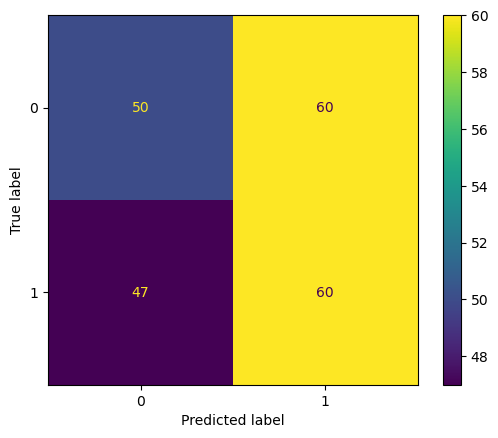

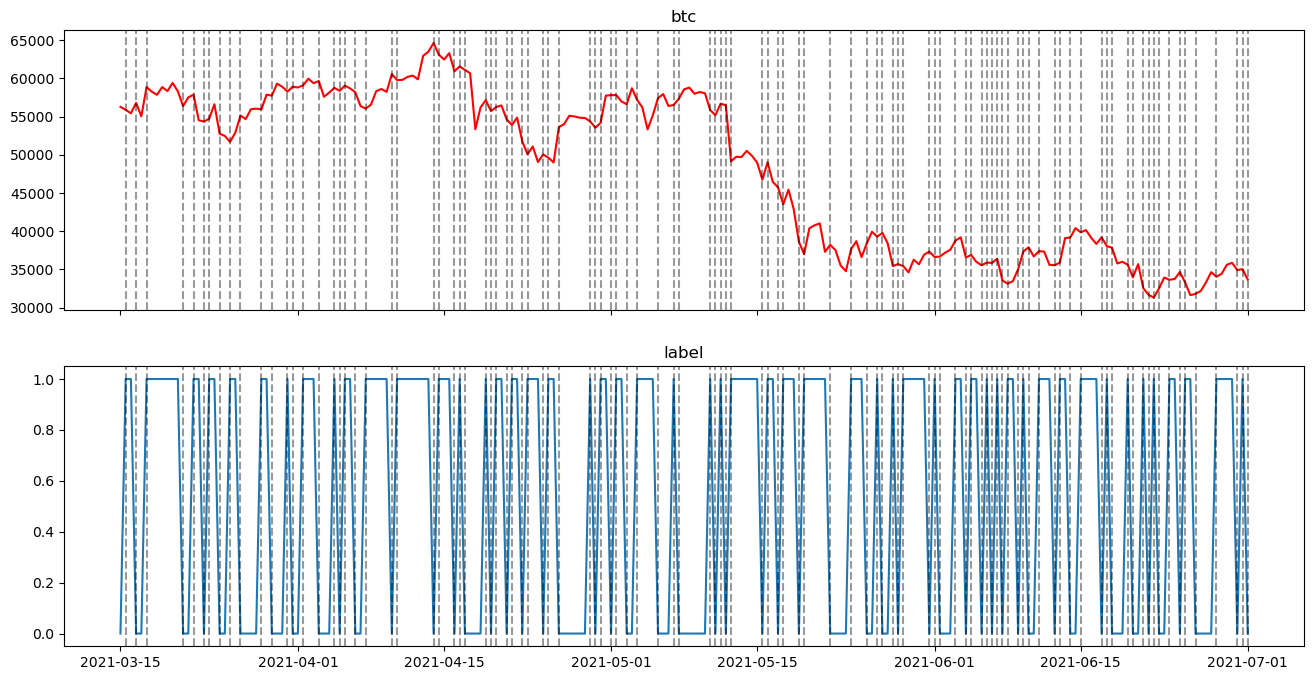

Model Returns:  -0.23059428335448906
Model Returns with short:  -0.11410143564359021
Buy and hold Returns:  -0.40146171373623796


datetime
2021-03-15 00:00:00+00:00    0
2021-03-15 12:00:00+00:00    1
2021-03-16 00:00:00+00:00    1
2021-03-16 12:00:00+00:00    0
2021-03-17 00:00:00+00:00    0
                            ..
2021-06-29 00:00:00+00:00    1
2021-06-29 12:00:00+00:00    1
2021-06-30 00:00:00+00:00    0
2021-06-30 12:00:00+00:00    1
2021-07-01 00:00:00+00:00    0
Length: 217, dtype: int32

In [41]:
classify_and_report(ab_200)

### Bullish market (uptrend)

In [42]:
X_train = X.loc[:cutoff_up_start]
y_train = (y.loc[:cutoff_up_start] >0).astype(int)
X_test = X.loc[cutoff_up_start:cutoff_up_end] 
y_test = (y.loc[cutoff_up_start:cutoff_up_end] > 0).astype(int)

              precision    recall  f1-score   support

           0       0.46      0.42      0.44       100
           1       0.55      0.59      0.57       119

    accuracy                           0.51       219
   macro avg       0.50      0.50      0.50       219
weighted avg       0.51      0.51      0.51       219



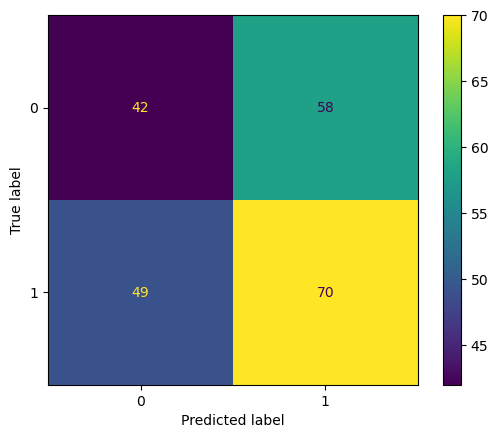

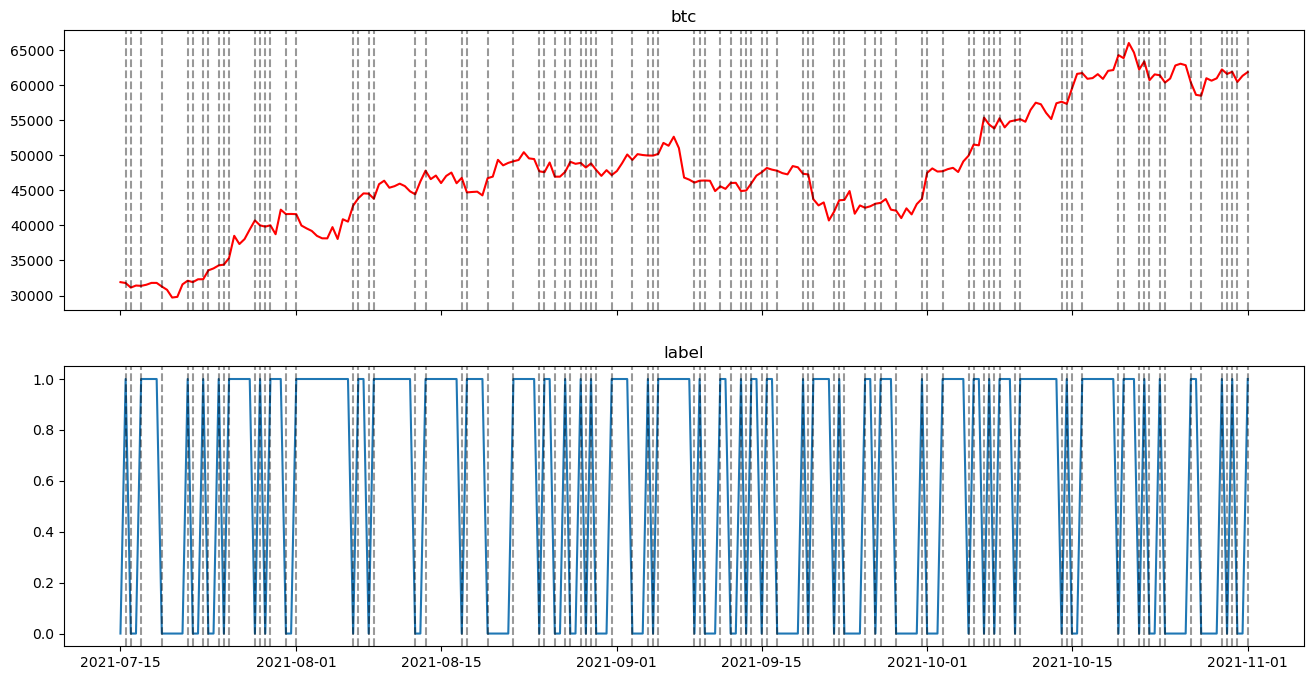

Model Returns:  0.23630683155251608
Model Returns with short:  -0.2607296408013722
Buy and hold Returns:  0.9385295483390821


datetime
2021-07-15 00:00:00+00:00    0
2021-07-15 12:00:00+00:00    1
2021-07-16 00:00:00+00:00    0
2021-07-16 12:00:00+00:00    0
2021-07-17 00:00:00+00:00    1
                            ..
2021-10-30 00:00:00+00:00    0
2021-10-30 12:00:00+00:00    1
2021-10-31 00:00:00+00:00    0
2021-10-31 12:00:00+00:00    0
2021-11-01 00:00:00+00:00    1
Length: 219, dtype: int32

In [43]:
classify_and_report(ab_200)

## XGBoost

In [44]:
xg = XGBClassifier(max_depth=4, scale_pos_weight=0.05)

### Diverse market (mixed trend)

In [45]:
X_train = X.loc[:diverse_cutoff ]
y_train = (y.loc[:diverse_cutoff ] >0).astype(int)
X_test = X.loc[diverse_cutoff :diverse_end ] 
y_test = (y.loc[diverse_cutoff :diverse_end ] > 0).astype(int)

[17:15:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       0.47      0.99      0.64       172
           1       0.50      0.01      0.01       191

    accuracy                           0.47       363
   macro avg       0.49      0.50      0.33       363
weighted avg       0.49      0.47      0.31       363



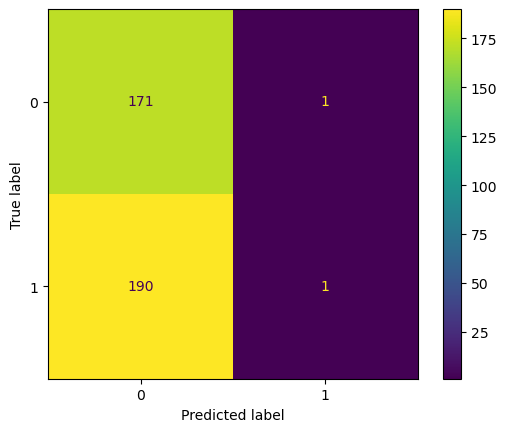

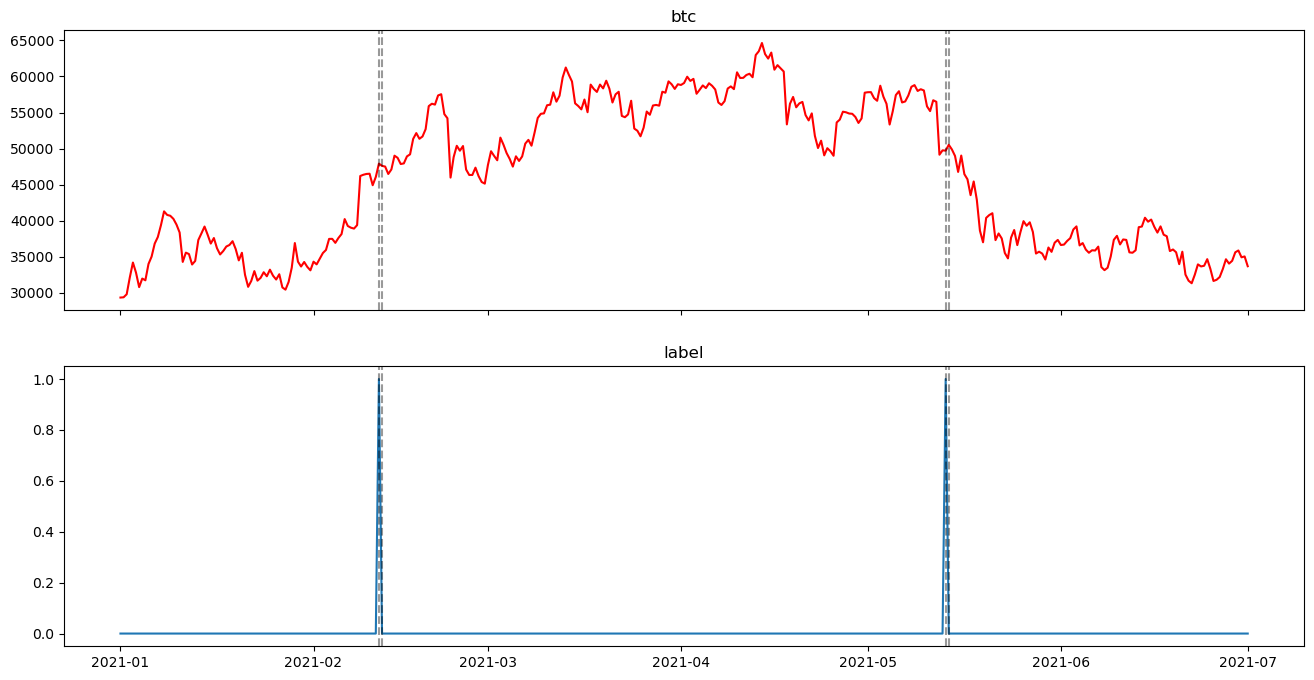

Model Returns:  0.03912111722485179
Model Returns with short:  -0.41128460308642856
Buy and hold Returns:  0.14806390008863413


datetime
2021-01-01 00:00:00+00:00    0
2021-01-01 12:00:00+00:00    0
2021-01-02 00:00:00+00:00    0
2021-01-02 12:00:00+00:00    0
2021-01-03 00:00:00+00:00    0
                            ..
2021-06-29 00:00:00+00:00    0
2021-06-29 12:00:00+00:00    0
2021-06-30 00:00:00+00:00    0
2021-06-30 12:00:00+00:00    0
2021-07-01 00:00:00+00:00    0
Length: 363, dtype: int32

In [46]:
classify_and_report(xg)

### Bearish market (downtrend)

In [47]:
X_train = X.loc[:cutoff_down_start]
y_train = (y.loc[:cutoff_down_start] >0).astype(int)
X_test = X.loc[cutoff_down_start:cutoff_down_end] 
y_test = (y.loc[cutoff_down_start:cutoff_down_end] > 0).astype(int)

[17:15:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       0.51      1.00      0.67       110
           1       0.00      0.00      0.00       107

    accuracy                           0.51       217
   macro avg       0.25      0.50      0.34       217
weighted avg       0.26      0.51      0.34       217



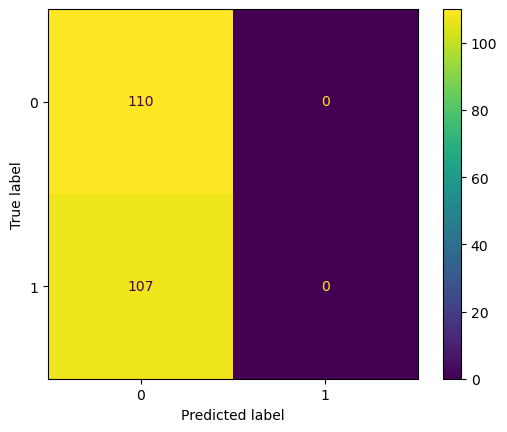

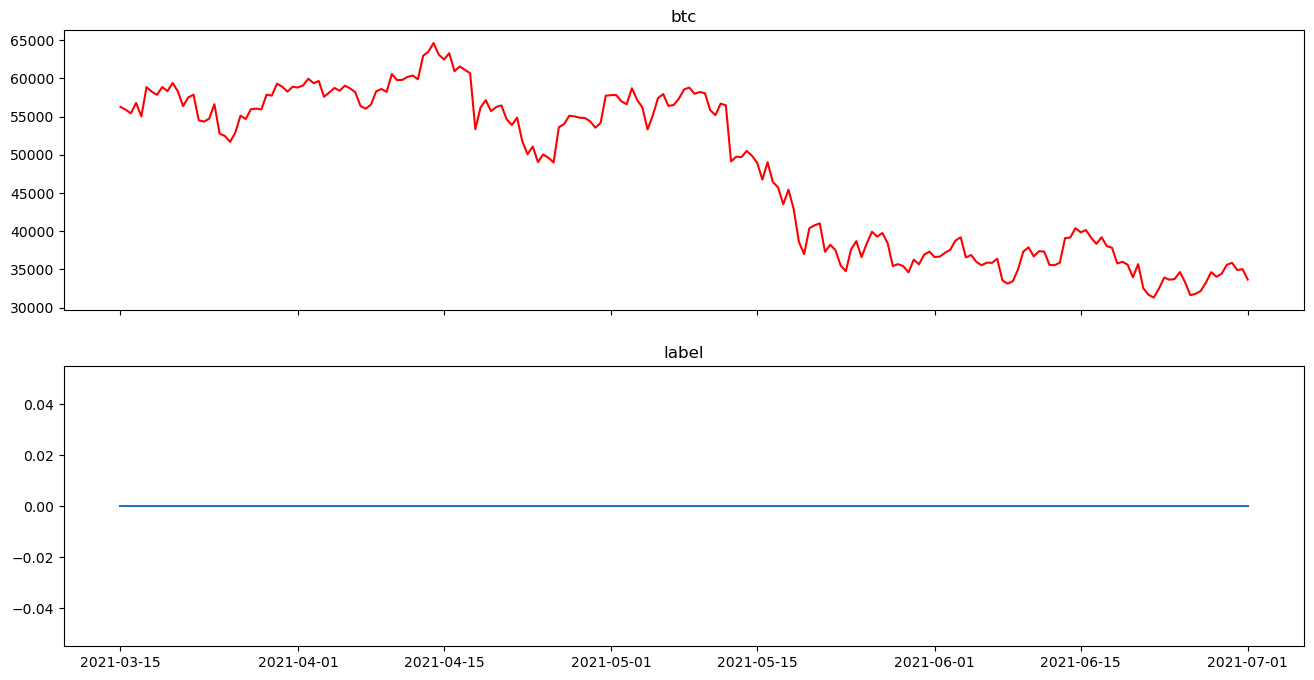

Model Returns:  0
Model Returns with short:  0.30262751935131527
Buy and hold Returns:  -0.40146171373623796


datetime
2021-03-15 00:00:00+00:00    0
2021-03-15 12:00:00+00:00    0
2021-03-16 00:00:00+00:00    0
2021-03-16 12:00:00+00:00    0
2021-03-17 00:00:00+00:00    0
                            ..
2021-06-29 00:00:00+00:00    0
2021-06-29 12:00:00+00:00    0
2021-06-30 00:00:00+00:00    0
2021-06-30 12:00:00+00:00    0
2021-07-01 00:00:00+00:00    0
Length: 217, dtype: int32

In [48]:
classify_and_report(xg)

### Bullish market (uptrend)

In [49]:
X_train = X.loc[:cutoff_up_start]
y_train = (y.loc[:cutoff_up_start] >0).astype(int)
X_test = X.loc[cutoff_up_start:cutoff_up_end] 
y_test = (y.loc[cutoff_up_start:cutoff_up_end] > 0).astype(int)

[17:15:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       0.45      0.98      0.62       100
           1       0.33      0.01      0.02       119

    accuracy                           0.45       219
   macro avg       0.39      0.49      0.32       219
weighted avg       0.39      0.45      0.29       219



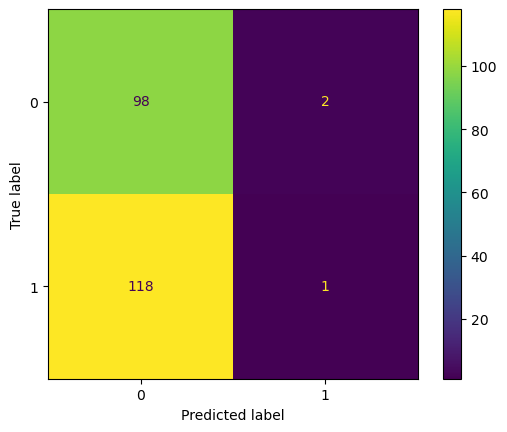

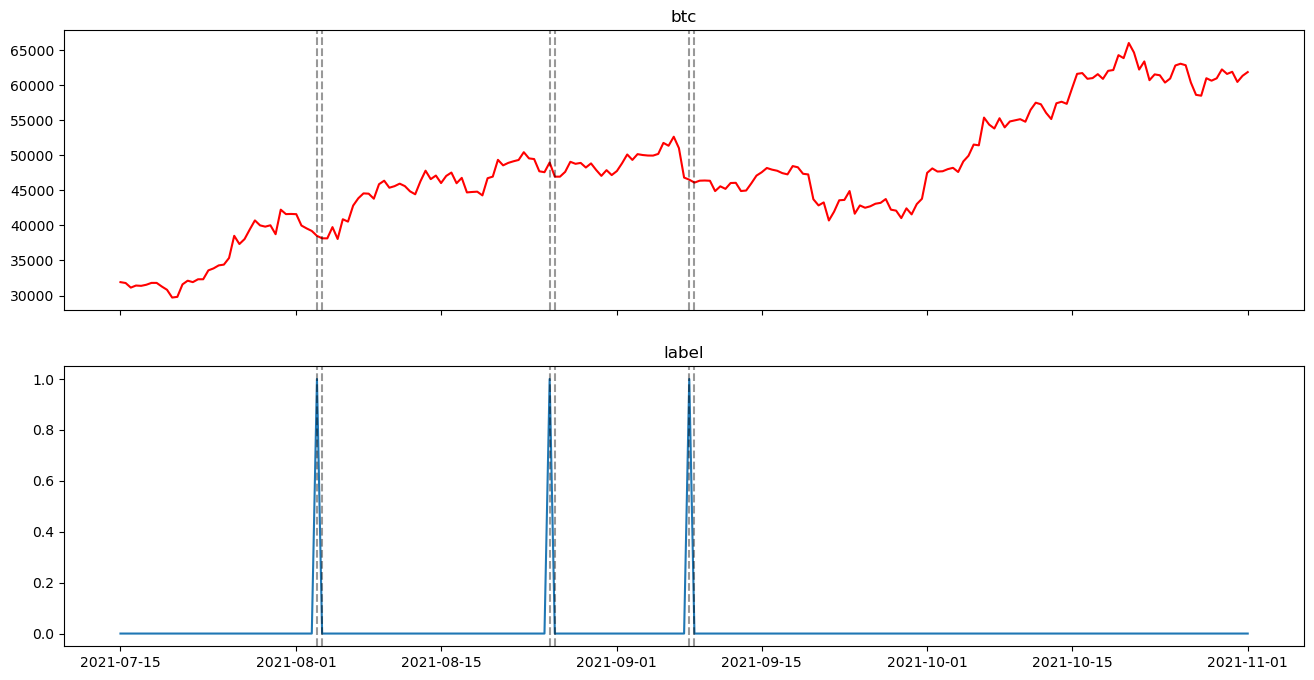

Model Returns:  0.004229745728520973
Model Returns with short:  -0.5515251832842223
Buy and hold Returns:  0.9385295483390821


datetime
2021-07-15 00:00:00+00:00    0
2021-07-15 12:00:00+00:00    0
2021-07-16 00:00:00+00:00    0
2021-07-16 12:00:00+00:00    0
2021-07-17 00:00:00+00:00    0
                            ..
2021-10-30 00:00:00+00:00    0
2021-10-30 12:00:00+00:00    0
2021-10-31 00:00:00+00:00    0
2021-10-31 12:00:00+00:00    0
2021-11-01 00:00:00+00:00    0
Length: 219, dtype: int32

In [50]:
classify_and_report(xg)

## Comparison of several models

In [51]:
diverse_cutoff = '2021-01-01 00:00:00+00:00'
diverse_end = '2021-07-01 00:00:00+00:00'
bearish_cutoff = '2021-03-15 00:00:00+00:00'
bearish_end = '2021-07-01 00:00:00+00:00'
bullish_cutoff = '2021-07-15 00:00:00+00:00'
bullish_end = '2021-11-01 00:00:00+00:00'
test_cutoff = '2021-11-01 00:00:00+00:00'

In [52]:
X_train = X.loc[:diverse_cutoff]
y_train = (y.loc[:diverse_cutoff] >0).astype(int)
X_val_diverse = X.loc[diverse_cutoff:diverse_end] 
y_val_diverse = (y.loc[diverse_cutoff:diverse_end:] > 0).astype(int)
X_val_bearish = X.loc[bearish_cutoff:bearish_end] 
y_val_bearish = (y.loc[bearish_cutoff:bearish_end:] > 0).astype(int)
X_val_bullish = X.loc[bullish_cutoff:bullish_end] 
y_val_bullish = (y.loc[bullish_cutoff:bullish_end:] > 0).astype(int)

In [53]:
models = {
    'xg': XGBClassifier(max_depth=4, scale_pos_weight=0.2, min_child_weight=1, n_estimators=500),
    'svm': SVC(probability=True, class_weight={1: 0.5, 0: 1}),
    'LogisticReg': LogisticRegression(class_weight={1: 0.5, 0: 1}),
    'AdaBoost': AdaBoostClassifier()
}

[17:15:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


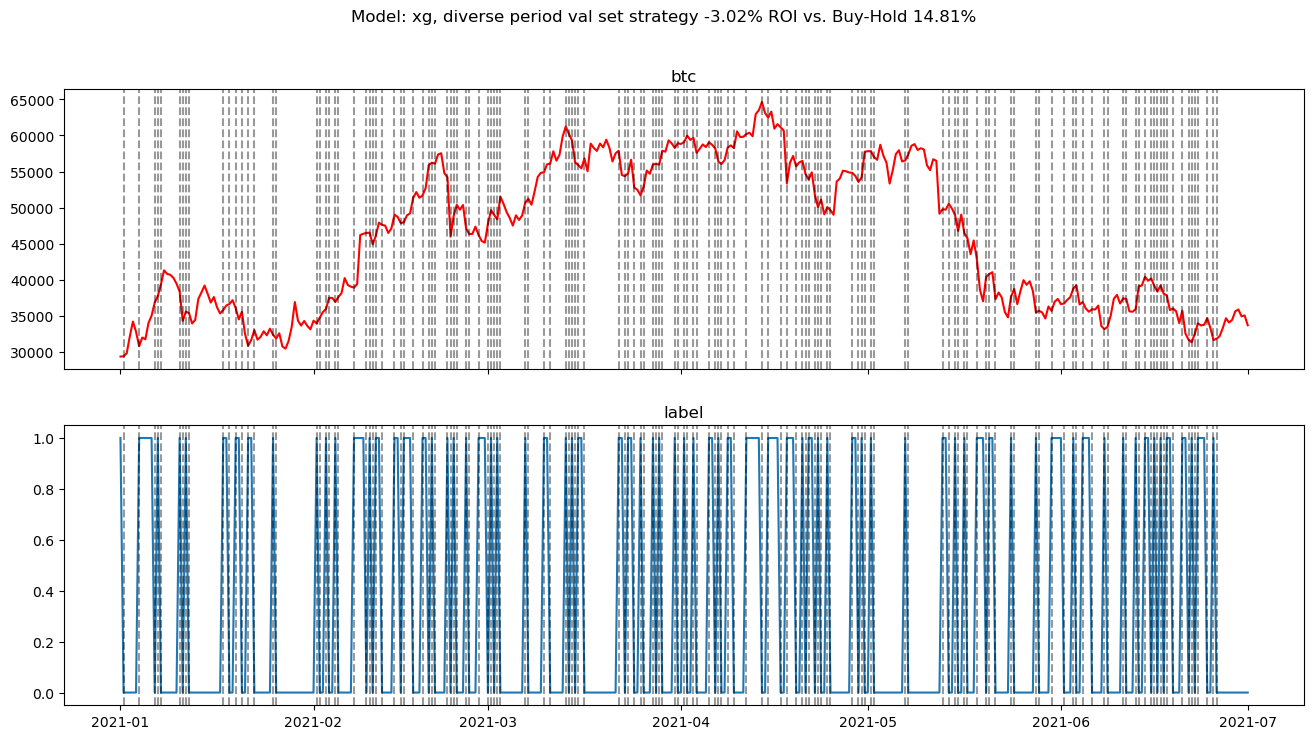

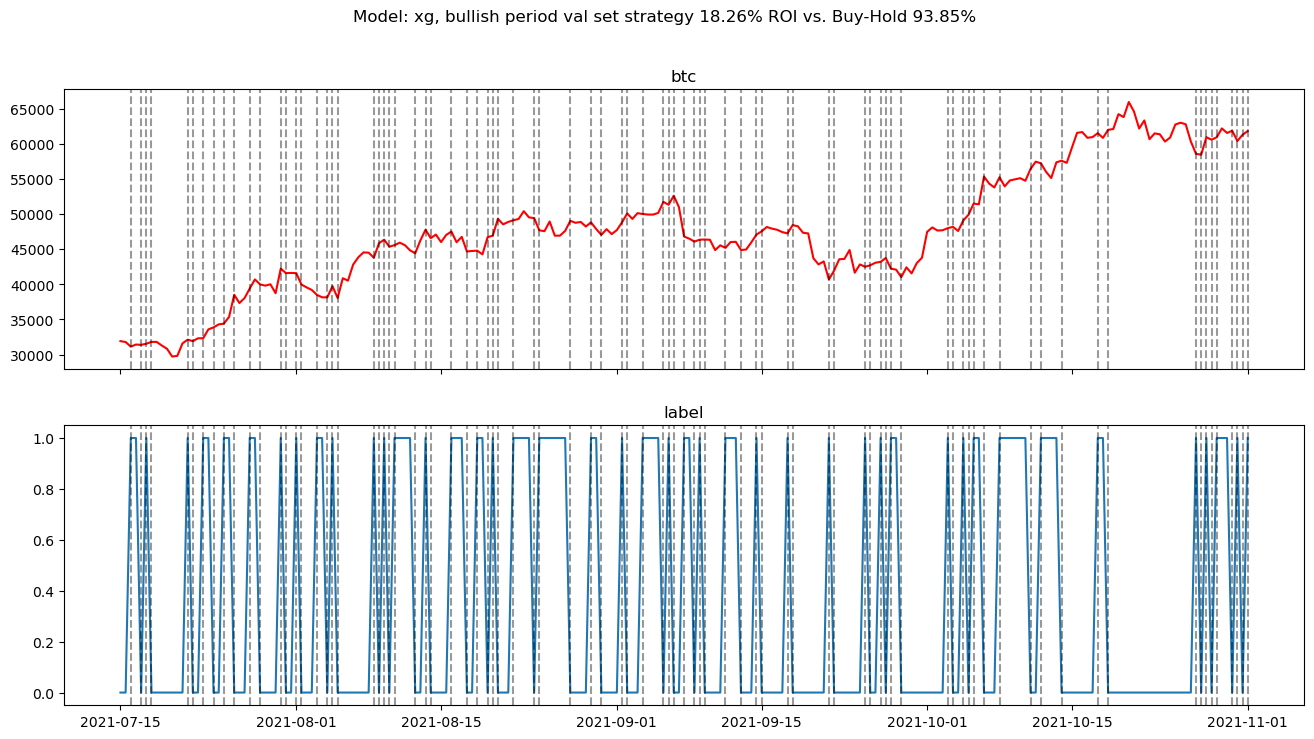

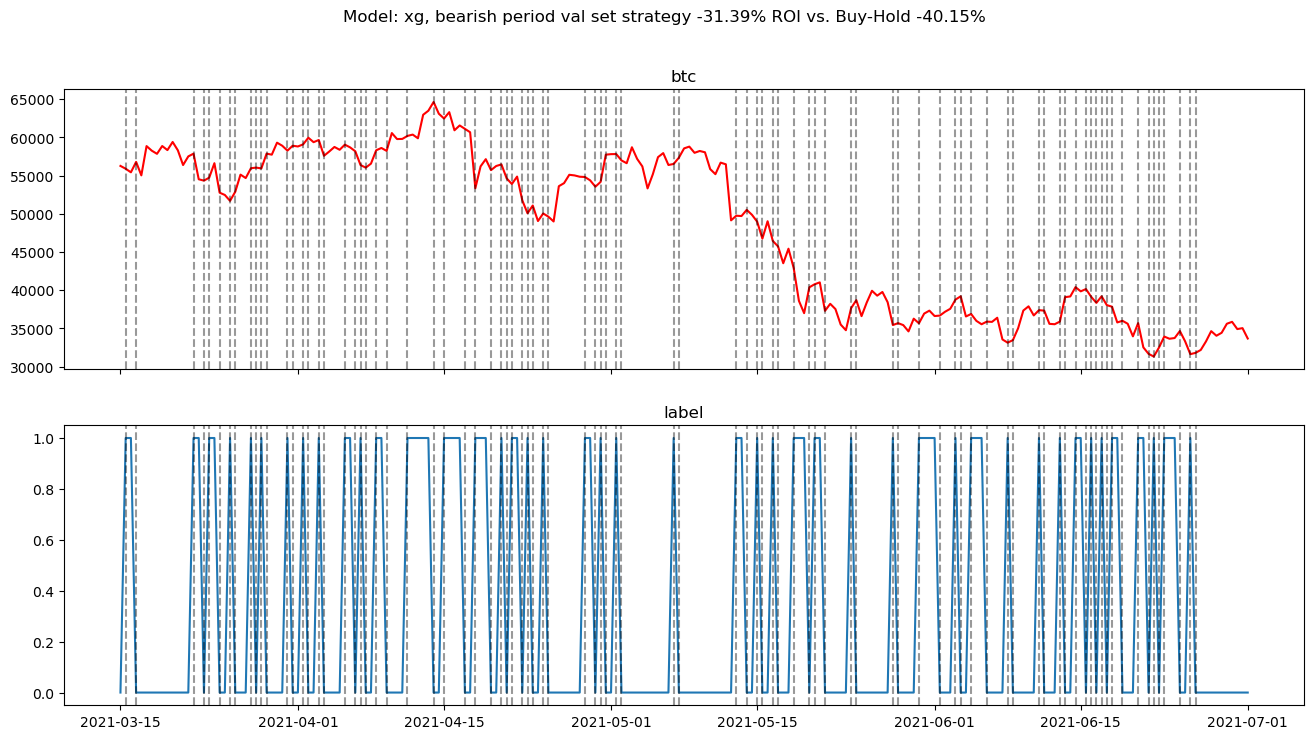

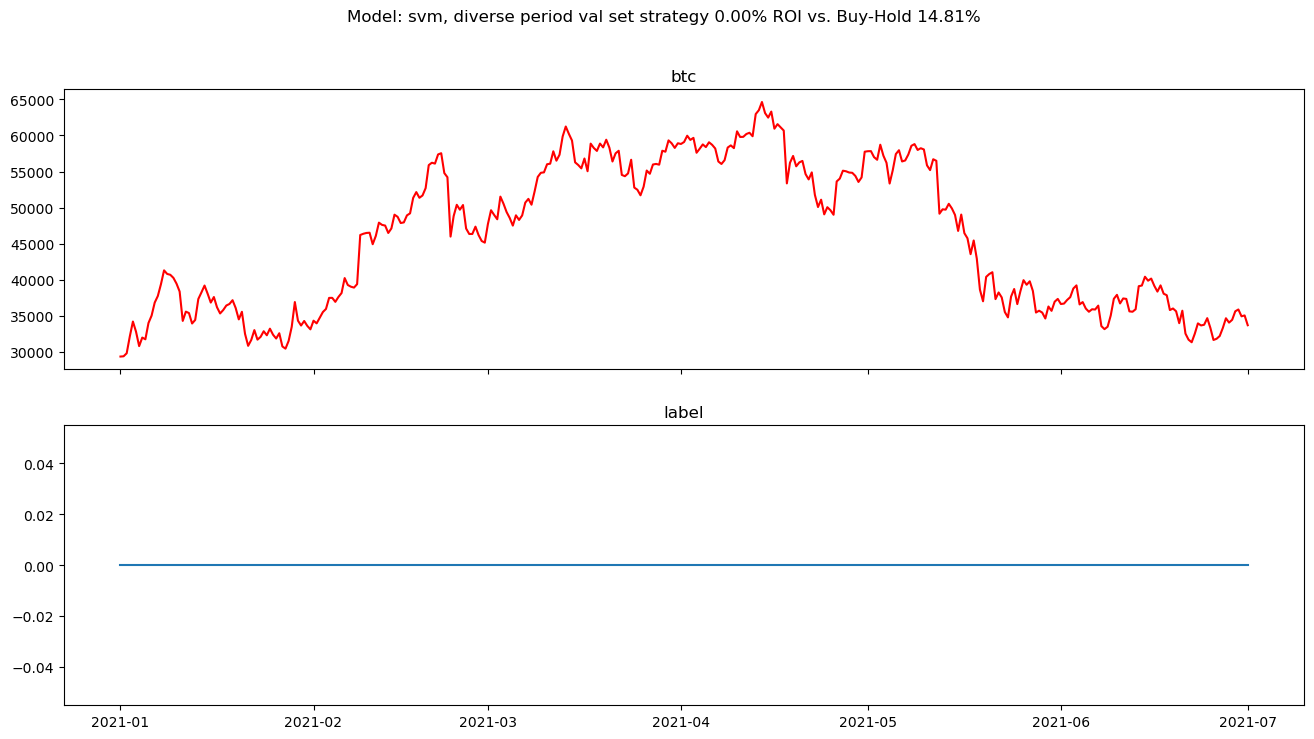

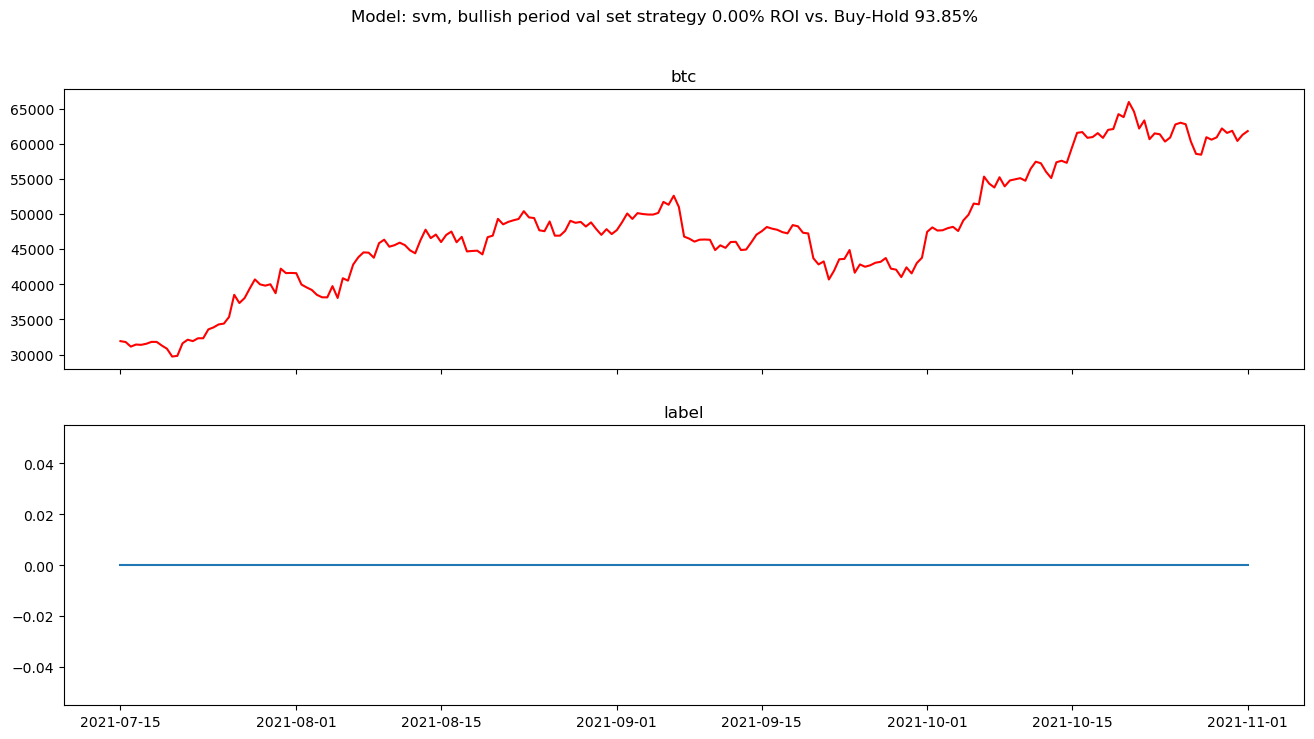

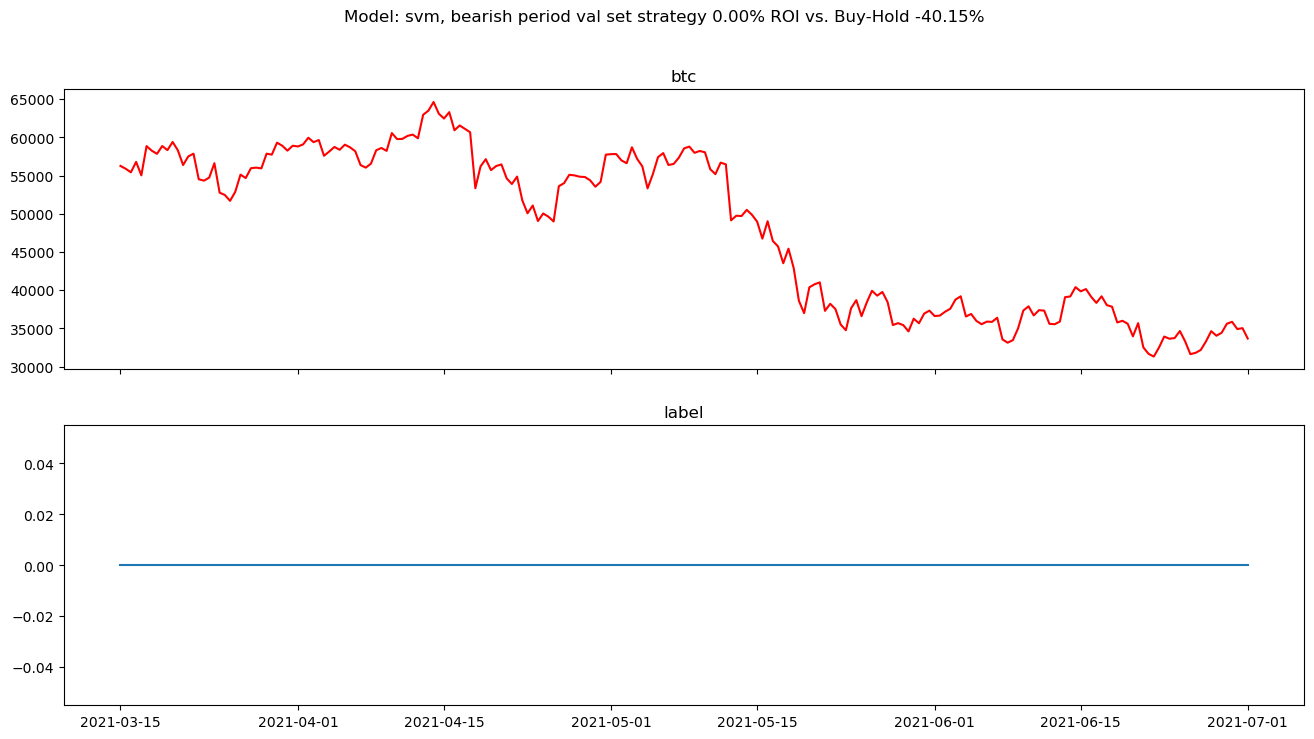

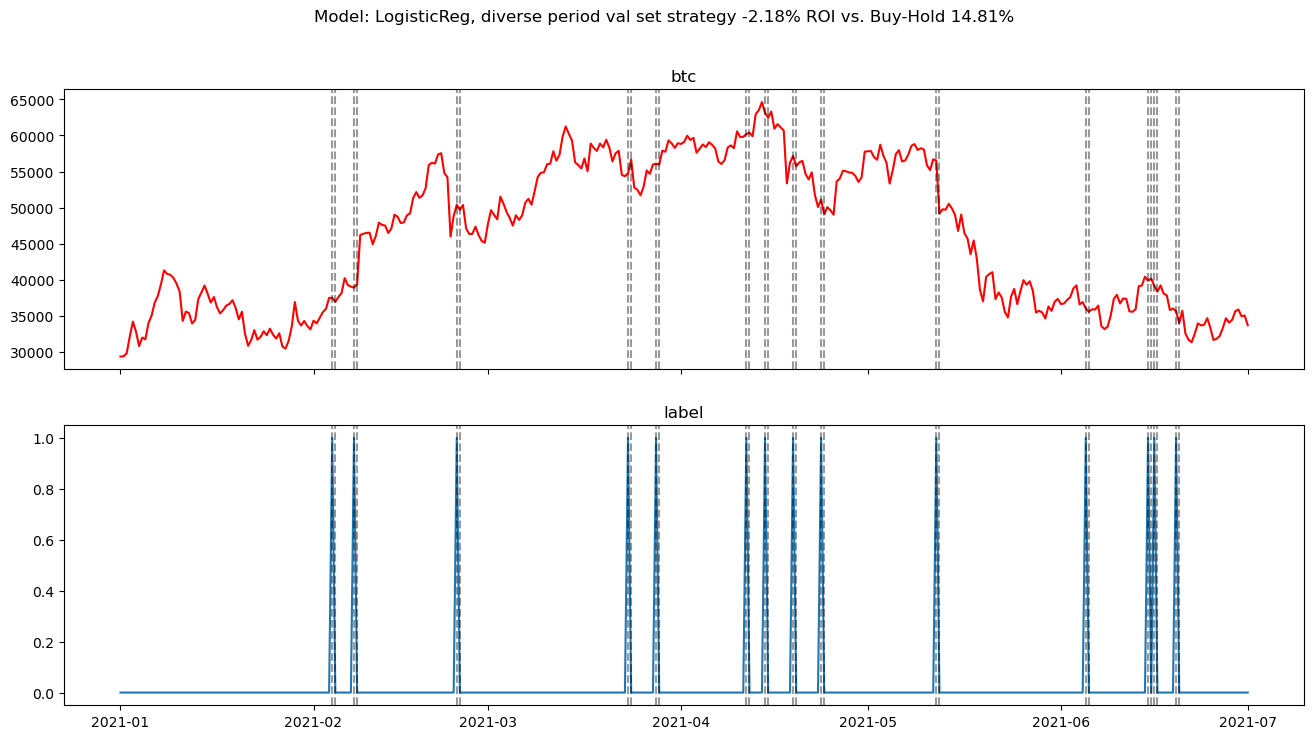

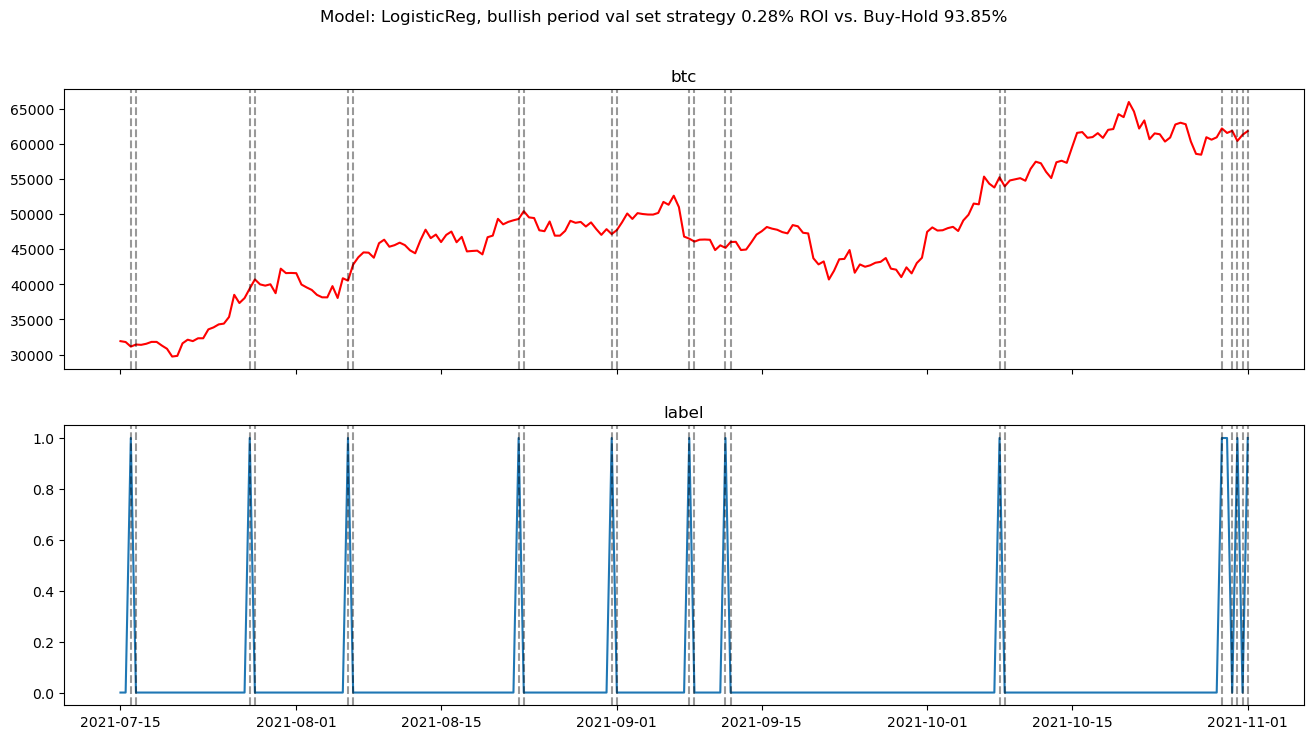

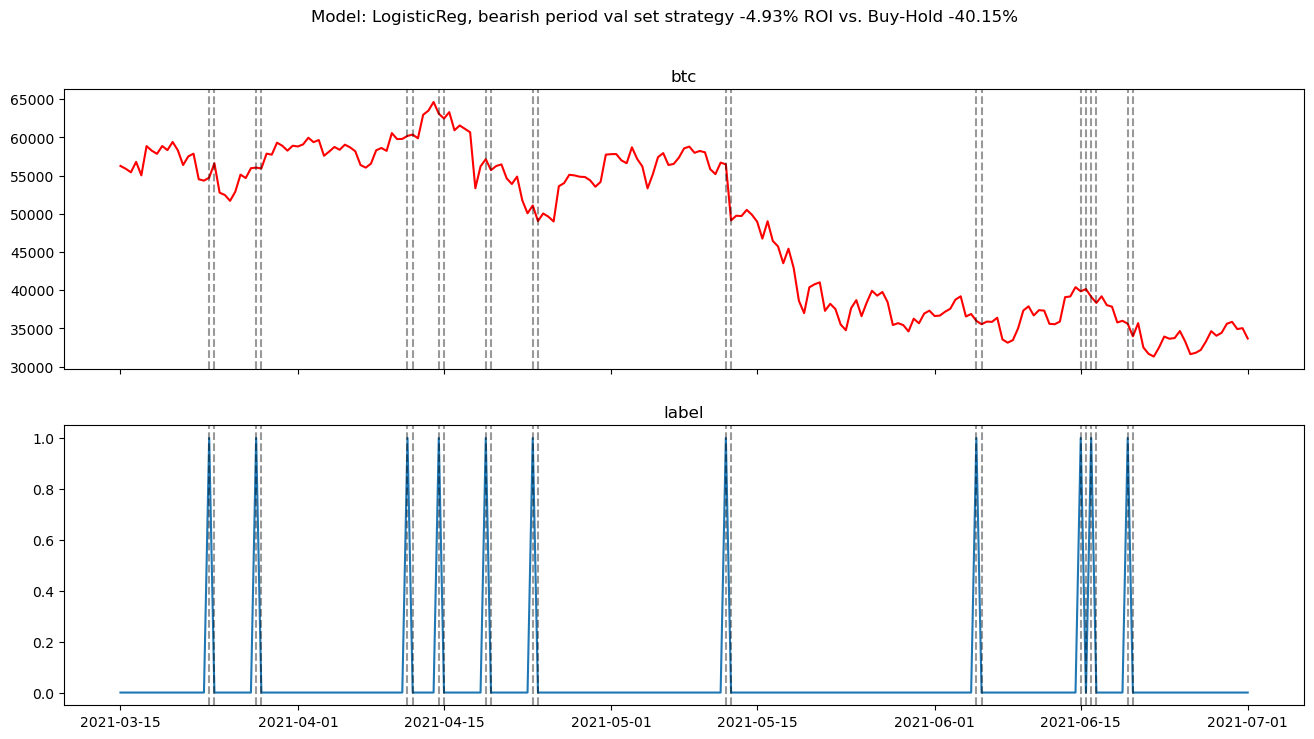

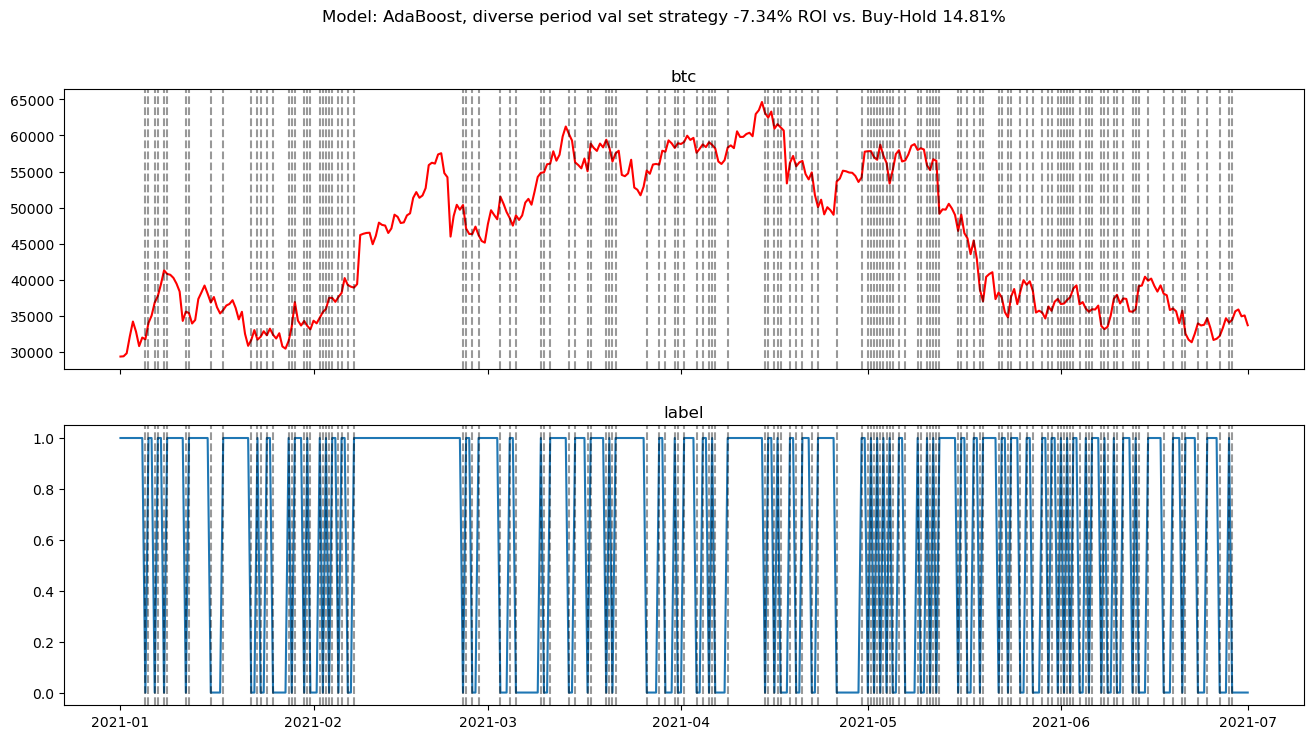

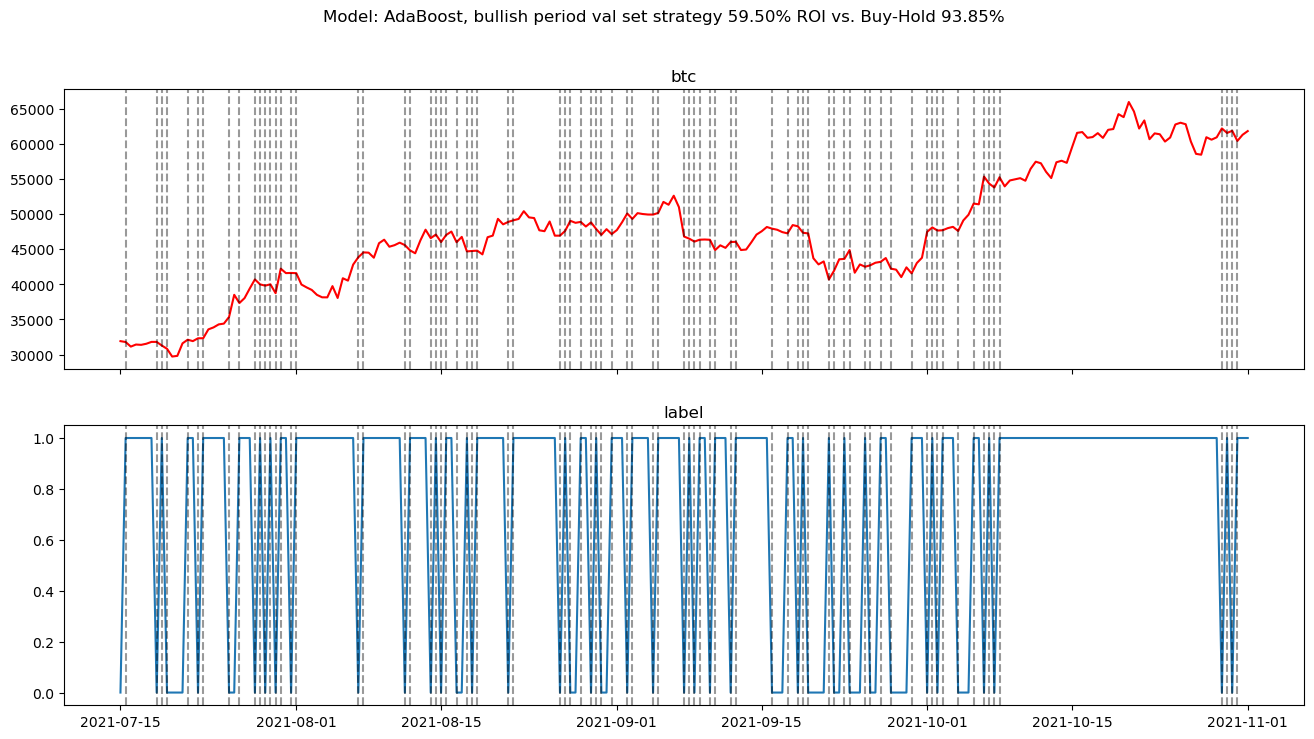

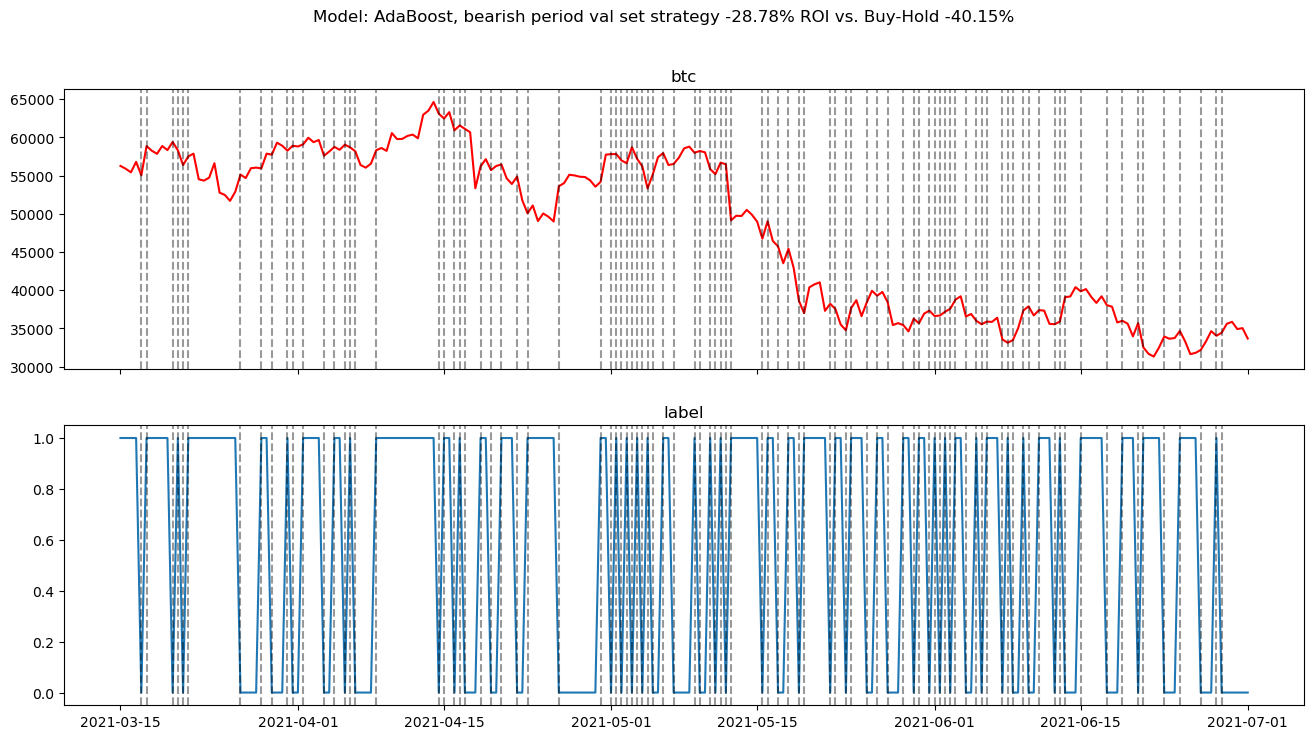

In [54]:
val_preds_dict = {'diverse': [], 'diverse buy hold': [], 'bullish': [
], 'bullish buy hold': [], 'bearish': [], 'bearish buy hold': [], }
for name, model in models.items():
    model.fit(X_train, y_train)
    val_preds = model.predict(X_val_diverse)
    R = calculate_returns(btc.loc[X_val_diverse.index]['price'], val_preds)
    RBH = buy_and_hold_return(btc.loc[X_val_diverse.index]['price'])
    val_preds_dict['diverse'].append(R)
    val_preds_dict['diverse buy hold'].append(RBH)
    title = f'Model: {name}, diverse period val set strategy {100*R:.2f}% ROI vs. Buy-Hold {100*RBH:.2f}%'
    plot_results(btc.loc[X_val_diverse.index]['price'], pd.Series(val_preds, index=X_val_diverse.index), title = title)

  
    val_preds = model.predict(X_val_bullish)
    R = calculate_returns(btc.loc[X_val_bullish.index]['price'], val_preds)
    val_preds_dict['bullish'].append(R)
    RBH = buy_and_hold_return(btc.loc[X_val_bullish.index]['price'])
    val_preds_dict['bullish buy hold'].append(RBH)
    title = f'Model: {name}, bullish period val set strategy {100*R:.2f}% ROI vs. Buy-Hold {100*RBH:.2f}%'
    plot_results(btc.loc[X_val_bullish.index]['price'], pd.Series(val_preds, index=X_val_bullish.index), title = title)
    
    val_preds = model.predict(X_val_bearish)
    R = calculate_returns(btc.loc[X_val_bearish.index]['price'], val_preds)
    val_preds_dict['bearish'].append(R)
    RBH = buy_and_hold_return(btc.loc[X_val_bearish.index]['price'])
    val_preds_dict['bearish buy hold'].append(RBH)
    title = f'Model: {name}, bearish period val set strategy {100*R:.2f}% ROI vs. Buy-Hold {100*RBH:.2f}%'
    plot_results(btc.loc[X_val_bearish.index]['price'], pd.Series(val_preds, index=X_val_bearish.index), title = title)



In [55]:
results = pd.DataFrame(val_preds_dict, index=models.keys())
results

,diverse,diverse buy hold,bullish,bullish buy hold,bearish,bearish buy hold
xg,-0.030175,0.148064,0.182625,0.93853,-0.313882,-0.401462
svm,0.000000,0.148064,0.000000,0.93853,0.000000,-0.401462
LogisticReg,-0.021819,0.148064,0.002832,0.93853,-0.049340,-0.401462
AdaBoost,-0.073362,0.148064,0.594978,0.93853,-0.287755,-0.401462
